In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

import env
import zillow_wrangle
import split_scale
import evaluate
import explore
import feature

# Data Science Pipeline

### Acquire
*Goal: Having a clean dataframe ready to prepare*

The ad hoc part includes summarizing your data as you read it in and begin to explore, look at the first few rows, data types, summary stats, column names, shape of the data frame, etc.

Brainstorming ideas, hypotheses, related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable, and also related to any ideas for new features you may have while first looking at the existing variables and challenge ahead of you.

Have a detailed README.md file for anyone who wants to check out your project. In this file should be a description of what the project is, and any instructions necessary for someone else to clone your project and run the code on their own laptop.

During project planning, think about what things in your project are nice to have, versus which things are need to have. For example, you might document that you will only worry about trying to scale your features after creating and evaluating a baseline model.

#### - I'm acquiring my data using wrangle_zillow

In [2]:
df = zillow_wrangle.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 16 columns):
id                              20778 non-null int64
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
fips                            20778 non-null float64
rawcensustractandblock          20778 non-null float64
regionidcounty                  20778 non-null float64
roomcnt                         20778 non-null float64
structuretaxvaluedollarcnt      20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
assessmentyear                  20778 non-null float64
landtaxvaluedollarcnt           20778 non-null float64
taxamount                       20778 non-null float64
id                              20778 non-null int64
logerror                        20778 non-null float64
transactiondate                 20778 non-null object
dtypes: float64(

### Hypothesis:
- $H_0$: Number of bathrooms and bedrooms in home, as well as square footage will not be leading factors in predicting property value
- $H_a$: Number of bathrooms, bedrooms and square footage will have a strong reciprocy for predicting property value.
- $H_a$: Using recursive feature elimination from SK.learn will proove a different variation of features that will predict features mentioned above but not discluding other possible features included in the dataset

### Prep
*Goal: leave this section with a dataset that is split into train and test ready to be analyzed. Data types are appropriate, missing values have been addressed, as have any data integrity issues.*

##### After a bit of exploring, I noticed that every fip code was for a county in california , added that as the state

In [4]:
state = 'California'
df['State'] = state
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California


#### There are only 3 unique fips numbers, so I added these to a seperate column called 'county'.

In [5]:
df.fips.unique()

array([6037., 6059., 6111.])

#### small for loop to convert fips to counties

In [6]:
county = []

for row in df['fips']:
    if row == 6037:
        county.append('Los Angelas')
    elif row == 6059:
        county.append('Orange')
    elif row == 6111:
        county.append('Ventura')
        
df['county'] = county        

#### Creating a new column called tax_rate which is the amount taxed divided by the home value to give us the percentage taxed.

In [7]:
df['tax_rate'] = df.taxamount / df.taxvaluedollarcnt

df['tax_rate'] = df.tax_rate.round(3)

### plotting the tax distribution

In [8]:
df.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,rawcensustractandblock,regionidcounty,roomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,id,logerror,transactiondate,State,county,tax_rate
0,2061546,2.0,3.0,1458.0,6037.0,6.037901e+07,3101.0,0.0,108890.0,136104.0,2016.0,27214.0,2319.90,1248,-0.362001,2017-06-23,California,Los Angelas,0.017
1,1834372,1.0,2.0,1421.0,6037.0,6.037232e+07,3101.0,0.0,11982.0,35606.0,2016.0,23624.0,543.69,1772,-0.146056,2017-06-30,California,Los Angelas,0.015
2,1923117,3.0,4.0,2541.0,6059.0,6.059064e+07,1286.0,0.0,434887.0,880456.0,2016.0,445569.0,9819.72,2028,0.021085,2017-06-01,California,Orange,0.011
3,2121349,2.0,3.0,1650.0,6037.0,6.037703e+07,3101.0,0.0,165000.0,614000.0,2016.0,449000.0,7673.19,3273,-0.325393,2017-06-01,California,Los Angelas,0.012
4,2093710,1.0,2.0,693.0,6037.0,6.037185e+07,3101.0,0.0,82416.0,274237.0,2016.0,191821.0,3267.47,3429,-0.005566,2017-06-29,California,Los Angelas,0.012


In [9]:
county_df = df[['county', 'tax_rate']]
county_df.head()

,county,tax_rate
0,Los Angelas,0.017
1,Los Angelas,0.015
2,Orange,0.011
3,Los Angelas,0.012
4,Los Angelas,0.012


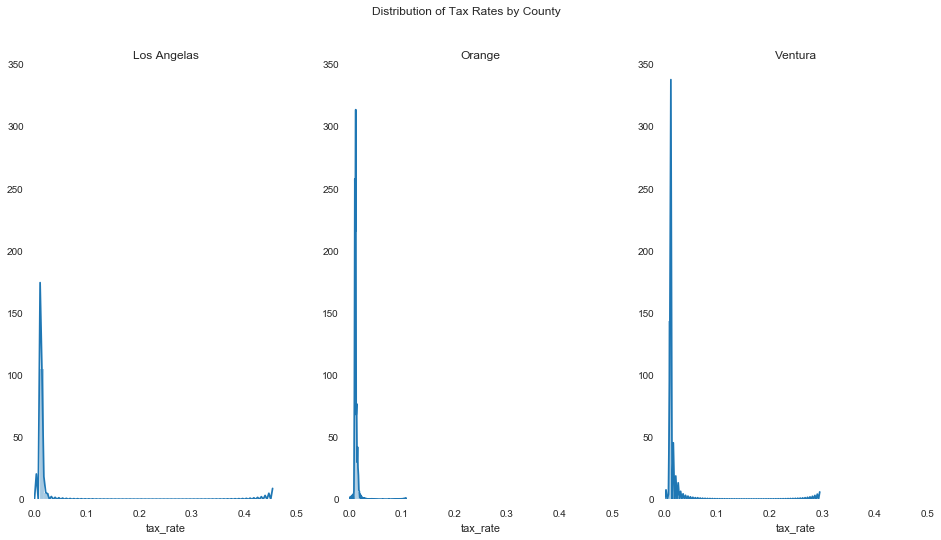

In [10]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.5)
plt.ylim(0, 350)

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.5)
plt.ylim(0, 350)

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.5)
plt.ylim(0, 350)


plt.show()

## There are some crazy outliers in the Los Angelas and Ventura counties. I will show the distribution by cutting those outliers from the data, as they are heavily influencing the shape of the distribution.

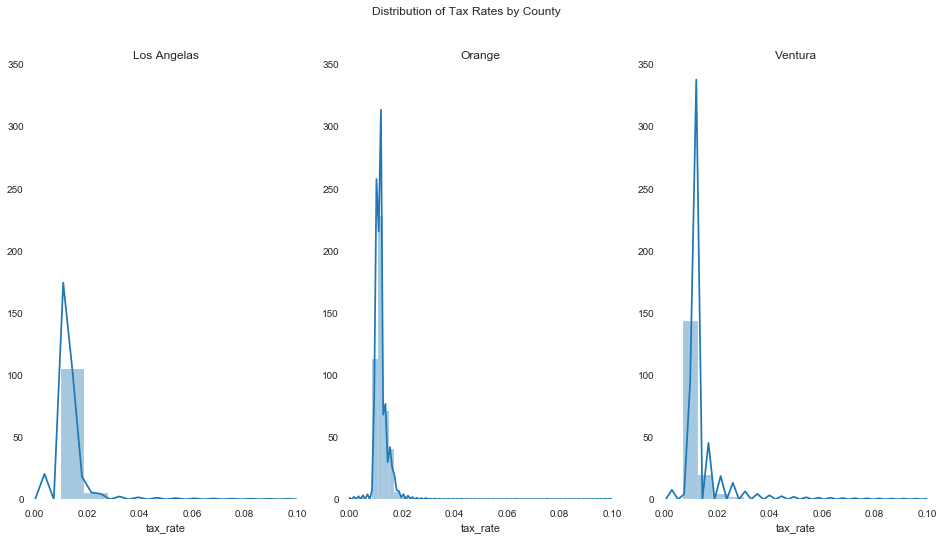

In [11]:
la = county_df[county_df.county == 'Los Angelas'].tax_rate
orange = county_df[county_df.county == 'Orange'].tax_rate
ventura = county_df[county_df.county == 'Ventura'].tax_rate

plt.figure(figsize=(16, 8))
plt.suptitle('Distribution of Tax Rates by County')

plt.subplot(131)
sns.distplot(la)
plt.title('Los Angelas')
plt.xlim(0, 0.1)
plt.ylim(0, 350)

plt.subplot(132)
sns.distplot(orange)
plt.title("Orange")
plt.xlim(0, 0.1)
plt.ylim(0, 350)

plt.subplot(133)
sns.distplot(ventura)
plt.title("Ventura")
plt.xlim(0, 0.1)
plt.ylim(0, 350)


plt.show()

The ad hoc part includes plotting the distributions of individual variables and using those plots to identify outliers and if those should be handled (and if so, how), identify unit scales to identify how to best scale the numeric data, as well as finding erroneous or invalid data that may exist in your dataframe.

### visualizing Data for pre-exploration

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 19 columns):
id                              20778 non-null int64
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
fips                            20778 non-null float64
rawcensustractandblock          20778 non-null float64
regionidcounty                  20778 non-null float64
roomcnt                         20778 non-null float64
structuretaxvaluedollarcnt      20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
assessmentyear                  20778 non-null float64
landtaxvaluedollarcnt           20778 non-null float64
taxamount                       20778 non-null float64
id                              20778 non-null int64
logerror                        20778 non-null float64
transactiondate                 20778 non-null object
State           

### a lot of these parameters aren't viable features for our model, so I wittled it down to 4 possible features and our target variable

In [13]:
bed_bath_and_beyond = df[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [14]:
bed_bath_and_beyond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20778 entries, 0 to 20801
Data columns (total 5 columns):
bathroomcnt                     20778 non-null float64
bedroomcnt                      20778 non-null float64
calculatedfinishedsquarefeet    20778 non-null float64
roomcnt                         20778 non-null float64
taxvaluedollarcnt               20778 non-null float64
dtypes: float64(5)
memory usage: 974.0 KB


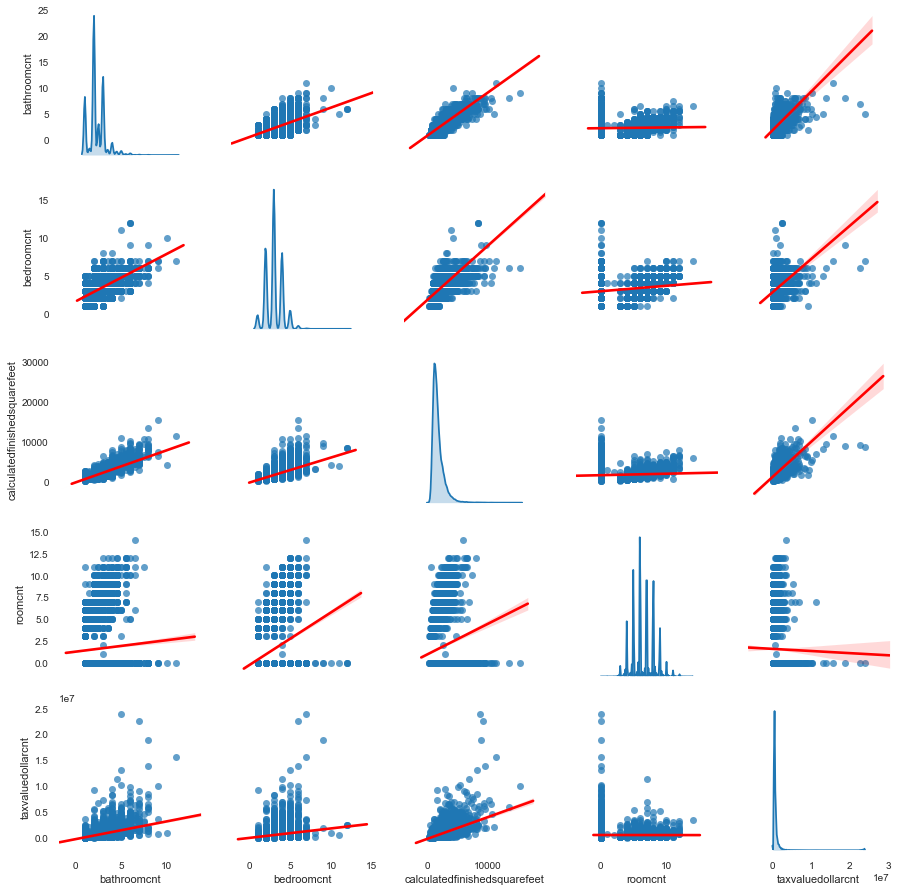

In [15]:
explore.plot_variable_pairs(bed_bath_and_beyond)

Add a data dictionary in your notebook that defines all fields used in your model and your analysis, and answers the question: why did you use the fields you used, e.g. why did you use bedroom_field1 over bedroom_field2, not why did you use number of bedrooms!

#### splitting our data

In [16]:
train, test = split_scale.split_my_data(df)

### Data Exploration
Goal: Address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, answers to specific questions your customers has asked, and information to move forward toward building a model.

Run at least 1 t-test and 1 correlation test (but as many as you need!)
Visualize all combinations of variables in some way(s).
What independent variables are correlated with the dependent?
Which independent variables are correlated with other independent variables?
Make sure to summarize your takeaways and conclusions. That is, the data science zillow team doesn't want to see just a bunch of dataframes/numbers/charts without any explanation, you should explain in the notebook what these dataframes/numbers/charts mean.

### using ***pearson's r*** to test correlation

#### testing for bathroom count & property value

In [17]:
x = df.bathroomcnt
y = df.taxvaluedollarcnt 

corr, p = stats.pearsonr(x, y)
corr, p

(0.5038602849897236, 0.0)

#### Here we visualize our findings

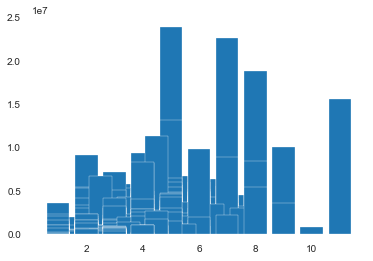

In [18]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between bedroom count and property value

In [19]:
x = df.bedroomcnt

corr, p = stats.pearsonr(x, y)
corr, p

(0.28346035958830285, 0.0)

#### Visuals for our correlation

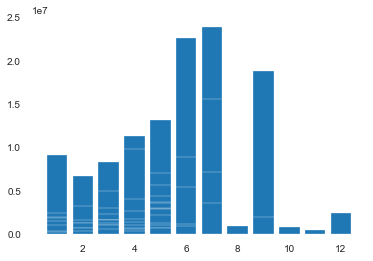

In [20]:
#plt.bar(x, y)
#plt.show()

#### testing for correlation between square footage and property value

In [21]:
x = df.calculatedfinishedsquarefeet

corr, p = stats.pearsonr(x, y)
corr, p

(0.6045735994042187, 0.0)

#### visuals

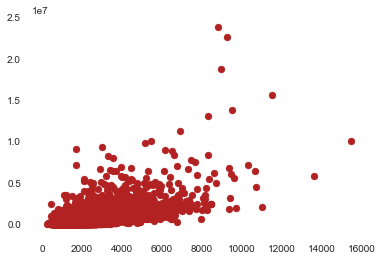

In [24]:
plt.scatter(x, y, c='firebrick')
plt.show()

### Modeling
Goal: develop a regression model that performs better than a baseline.

In [27]:
train = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]
test = test[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt','taxvaluedollarcnt']]

In [28]:
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train.taxvaluedollarcnt
X_test = test.drop(columns=['taxvaluedollarcnt'])
y_test = test.taxvaluedollarcnt

#### developing baseline model

In [29]:
y

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,roomcnt
8527,1.0,2.0,912.0,0.0
2882,1.0,2.0,756.0,0.0
4969,3.0,2.0,1364.0,0.0
955,2.5,3.0,1435.0,5.0
2061,1.0,2.0,756.0,0.0


You must evaluate a baseline model, and show how the model you end up with performs better than that.

Your notebook will contain various algorithms and/or hyperparameters tried, along with the evaluation code and results, before settling on the final algorithm.

Be sure and evaluate your model using the standard techniques: plotting the residuals, computing the evaluation metric (SSE, RMSE, and/or MSE), comparing to baseline, plotting 
y
 by 
^
y
.

model.py: will have the functions to fit, predict and evaluate the final model on the test data set.